In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import lmfit
from math import *

# Circle Fitting Research

## Introduction

This document is an exploration into the mathematics and algorithms of fitting lines and circles to a limited number of points which are a subset of an aircraft track.

## Data

In [2]:
def plot_data(dataset):
    x = []
    y = []

    for x_coord, y_coord in dataset:
        x.append(x_coord)
        y.append(y_coord)

    plt.scatter(x, y)

### data1
an aircraft travelling in more or less a straight line (perhaps with a slight curve)

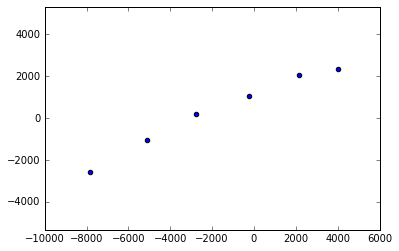

In [3]:
data1 = [[-7823.439561574536, -2568.6287717351497],
[-5107.037760476856, -1043.730245427465],
[-2762.7301083133757, 190.28046761840392],
[-259.35055129732217, 1076.7365979969445],
[2135.210021244198, 2041.7607403979657],
[4013.295597771261, 2335.1731250977123]]

plot_data(data1)
plt.axes().set_aspect('equal', 'datalim')

### data2
noisy data of an aircraft turning

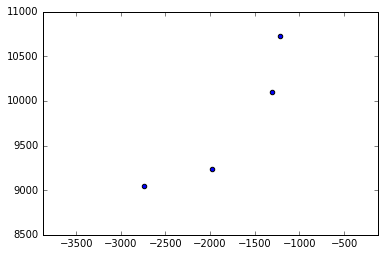

In [4]:
data2 = [[-2736.5842226839904, 9051.690473155024],
[-1973.134855393139, 9237.219387656745],
[-1307.9423416823379, 10095.120237700188],
[-1212.8163721100887, 10729.934781668326]]

plot_data(data2)
plt.axes().set_aspect('equal', 'datalim')

## Line Fitting

### Scipy Line Fitting

This is a first foray into doing line fitting using minimization of perpendicular offsets using scipy's minimization function.

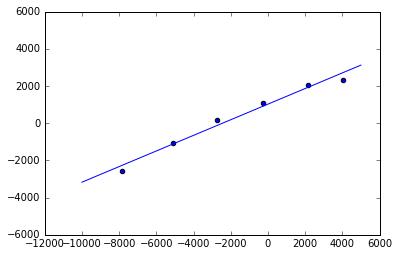

In [5]:
def perpendicular_distance(m, c, point):
    """returns a positive if on the right side of the line
    returns a negative if on the left side of the line"""
    a = m
    x1 = point[0]
    y1 = point[1]
    
    d = (a*x1 - y1 + c)/(sqrt(a*a + 1))
    return d

def least_squares_distance(m, c, points):
    distance_sum = 0
    for point in points:
        distance_sum += perpendicular_distance(m, c, point)**2
    
    return distance_sum

def func(x, *args):
    return least_squares_distance(x[0], x[1], args[0])

retval = scipy.optimize.minimize(func, [0,0], args=(data1))
m = retval.x[0]
c = retval.x[1]

plot_data(data1)

x = np.linspace(-10000, 5000)
y = []
for val in x:
    y.append(val*m + c)

    
plt.plot(x, y)
plt.axes().set_aspect('equal', 'datalim')


# least_squares_distance(1, 1000, data1)

    

### Newton Line Fitting

### Gauss-Newton Line Fitting

## Circle Fitting

### three point circle solver

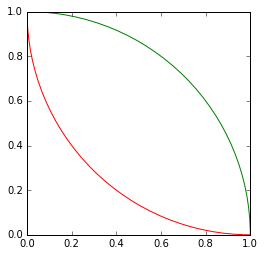

In [6]:
class Circle:
    def __init__(self, pos, radius):
        self.pos = pos
        self.radius = radius

    
    @staticmethod
    def from_three_points(p1, p2, p3):
        dy1 = p2[1] - p1[1]
        dx1 = p2[0] - p1[0]
        dy2 = p3[1] - p2[1]
        dx2 = p3[0] - p2[0]
        
        slope1 = dy1/dx1
        slope2 = dy2/dx2
        
        x = (slope1*slope2*(p1[1] - p3[1]) + slope2*(p1[0] + p2[0]) - slope1*(p2[0] + p3[0]))/(2*(slope2-slope1))
        y = -1*(x - (p1[0] + p2[0])/2)/slope1 + (p1[1] + p2[1])/2
        
        x1 = x - p1[0]
        y1 = y - p1[1]
        r = sqrt(x1*x1 + y1*y1)
        
        return Circle([x,y], r)
    
    def get_plot(self, **kwargs):
        return plt.Circle((self.pos[0], self.pos[1]), self.radius, **kwargs)
    
    def __str__(self):
        return "Circle([{0},{1}],{2})".format(self.pos[0], self.pos[1], self.radius)
    
    def distance2(self, point):
        return (sqrt((point[0] - self.pos[0])**2 + (point[1] - self.pos[1])**2) - self.radius)**2
    


c1 = Circle([1,1], 1)
c2 = Circle.from_three_points([-1, 0], [0, 1], [1, 0])

fig, ax = plt.subplots()
ax.add_artist(c1.get_plot(edgecolor="r", facecolor="none"))
ax.add_artist(c2.get_plot(edgecolor="g", facecolor="none"))
ax.set_aspect('equal')

### Scipy Minimize Circle Fitting
The following two cells demonstrate using scipy's minimize function to solve for circles using the conventional parameterization:

$$d_i = \sqrt{(x_i - a)^2 + (y_i - b)^2} - R$$
$$F =  \sum_{i=1}^{n}d_i^2$$

Where F is the function we are trying to minimize.

Guess(green): Circle([-2676.9263298024503,10469.756101355182],1419.3199745179995)
Answer(red): Circle([-2744.1154157915385,10576.023919859705],1530.7115839583885)


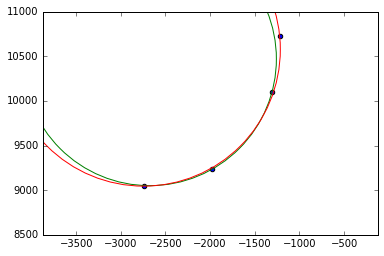

In [7]:

def circle_ri(a, b, radius, points):
    r_sum = 0
    c = Circle([a, b], radius)
    for point in points:
        r_sum += c.distance2(point)
    
    return r_sum

def func(x, *args):
    return circle_ri(x[0], x[1], x[2], args[0])

c1 = Circle.from_three_points(data2[0], data2[1], data2[2])

retval = scipy.optimize.minimize(func, [c1.pos[0],c1.pos[1],c1.radius], args=(data2))
a = retval.x[0]
b = retval.x[1]
r = retval.x[2]

c2 = Circle([a,b], r)


plot_data(data2)

print("Guess(green):", c1)
print("Answer(red):", c2)


ax = plt.gca()
ax.add_artist(c1.get_plot(edgecolor="g", facecolor="none"))
ax.add_artist(c2.get_plot(edgecolor="r", facecolor="none"))

plt.axes().set_aspect('equal', 'datalim')


Guess(green): Circle([45793.89384213992,-94898.80121838693],106769.28015751315)
Answer(red): Circle([12107.017055118396,-33336.20943681085],36638.49292318794)


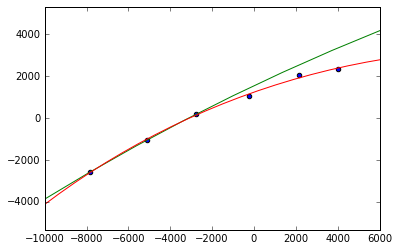

In [8]:
c1 = Circle.from_three_points(data1[0], data1[1], data1[2])

retval = scipy.optimize.minimize(func, [c1.pos[0],c1.pos[1],c1.radius], args=(data1))
a = retval.x[0]
b = retval.x[1]
r = retval.x[2]

c2 = Circle([a,b], r)


x = []
y = []

for x_coord, y_coord in data1:
    x.append(x_coord)
    y.append(y_coord)

plt.scatter(x, y)

print("Guess(green):", c1)
print("Answer(red):", c2)


ax = plt.gca()
ax.add_artist(c1.get_plot(edgecolor="g", facecolor="none"))
ax.add_artist(c2.get_plot(edgecolor="r", facecolor="none"))

plt.axes().set_aspect('equal', 'datalim')

### SciPy Levenberg-Marquardt Least-Squares Circle Fitting

Guess(green): Circle([45793.89384213992,-94898.80121838693],106769.28015751315)
Answer(red): Circle([12051.872411956107,-32914.71010089948],36234.900858877416)


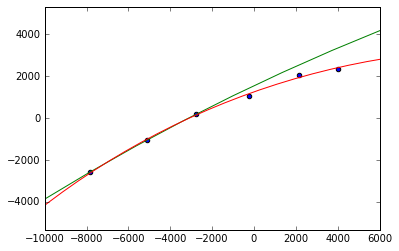

In [10]:
def circle_ri(a, b, radius, points):
    residuals = []
    c = Circle([a, b], radius)
    for point in points:
        residuals.append(c.distance2(point))
    
    return residuals

def func(x, *args):
    return circle_ri(x[0], x[1], x[2], args)

c1 = Circle.from_three_points(data1[0], data1[1], data1[2])

retval = scipy.optimize.least_squares(func, [c1.pos[0],c1.pos[1],c1.radius], args=(data1), method="lm")
a = retval.x[0]
b = retval.x[1]
r = retval.x[2]

c2 = Circle([a,b], r)


plot_data(data1)

print("Guess(green):", c1)
print("Answer(red):", c2)


ax = plt.gca()
ax.add_artist(c1.get_plot(edgecolor="g", facecolor="none"))
ax.add_artist(c2.get_plot(edgecolor="r", facecolor="none"))

plt.axes().set_aspect('equal', 'datalim')

Guess(green): Circle([-2676.9263298024503,10469.756101355182],1419.3199745179995)
Answer(red): Circle([-2749.8969143634604,10575.118314312538],1533.689331374633)


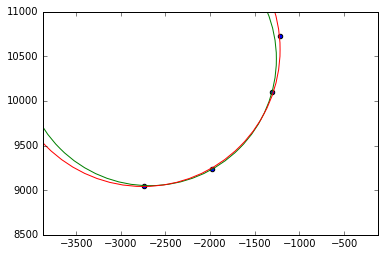

In [11]:
c1 = Circle.from_three_points(data2[0], data2[1], data2[2])

retval = scipy.optimize.least_squares(func, [c1.pos[0],c1.pos[1],c1.radius], args=(data2), method="lm")
a = retval.x[0]
b = retval.x[1]
r = retval.x[2]

c2 = Circle([a,b], r)

plot_data(data2)

print("Guess(green):", c1)
print("Answer(red):", c2)


ax = plt.gca()
ax.add_artist(c1.get_plot(edgecolor="g", facecolor="none"))
ax.add_artist(c2.get_plot(edgecolor="r", facecolor="none"))

plt.axes().set_aspect('equal', 'datalim')